In [186]:
import sys  
# sys.path.append('/home/josorior/kinetick/source')
sys.path.append('/home/juanfelipe/Desktop/research/kinetick/source')

In [187]:
# Standard tool packages
import jax
jax.config.update("jax_enable_x64", True)
from jax import grad, jacfwd, hessian
from jax import vmap
import jax.numpy as jnp
from jax.numpy import logical_and
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
# My tools
from models import *
from mykernels import get_gaussianRBF, get_matern_5_2
# Settings
#plt.style.use('seaborn-v0_8')
plt.rcParams["figure.figsize"] = (5, 5)

## PDE

Let $M(x) = \exp\left(-0.5(x_1^2 + x_2^2)\right)$. The Fokker-Planck equation in 2d is given by
$$
\begin{align*}

\partial_t \rho (t,x) &= \text{div}\left(M(x)\nabla\left(\frac{\rho(t,x)}{M(x)}\right)\right) & \text{for } t >0, x \in \Omega = (-5,5)^2 \\
\rho(0,x) &= \rho^0(x), &\text{for } x \in \Omega \\
\nabla\left(\frac{\rho(t,x)}{M(x)} \right)\cdot \mathbf{n} &= 0, & \text{for } t >0, x \in \partial\Omega = (-5,5)^2
\end{align*}
$$
whose analytical solution is known to be
$$
\rho(t, x)=\frac{1}{2 \pi\left(1-e^{-2 t}\right)} e^{-\frac{x_1^2+x_2^2}{2\left(1-e^{-2 t}\right)}}.
$$

We will use the kernel method in closed form since the PDE operator is linear.


In [188]:
# True solution
def fp_sol(x,t):
    K = 2*(1-jnp.exp(-2*t))
    return 1/(K*jnp.pi)*jnp.exp(-(jnp.sum(x**2))/K)

fp_sol = vmap(fp_sol,in_axes=(0,None)) # vmap'ed

## Kernel solution

Choose a kernel

In [189]:
k = get_gaussianRBF(0.25)

First we choose collocation pointsets $\Omega^*\subset\Omega$ and $\Omega^*\subset\partial\Omega$

In [190]:
# a in [-a,a]^2
a = 5
# \Omega
# n = 51
n = int(jnp.sqrt(500))
full_grid = jnp.linspace(-a,a,n)
interior_grid = full_grid[1:-1]
X,Y = jnp.meshgrid(*([interior_grid]*2))
interior_points = jnp.vstack([X.flatten(),Y.flatten()]).T
n_interior = len(interior_points)

# \partial\Omega
bottom = jnp.vstack([full_grid,-a*jnp.ones(n)]).T
top = jnp.vstack([full_grid,a*jnp.ones(n)]).T

left = jnp.vstack([-a*jnp.ones(n-2),interior_grid]).T
right = jnp.vstack([a*jnp.ones(n-2),interior_grid]).T

hor_points = jnp.vstack([bottom,top])
vert_points = jnp.vstack([left,right])

n_boundary = len(hor_points) + len(vert_points)

Build the kernel matrix $K(\phi,\phi)$ where $\phi = [\phi_\Omega, \phi_{\partial\Omega}]$ and
$$
\phi_\Omega \left(\square\right) = \delta_{x}\left(\square\right) - h\left(\delta_{x} \circ \text{div}\left(M(x)\nabla\left(\frac{\square}{M(x)}\right)\right)\right) \qquad \text{for } x\in \Omega
$$
$$
\phi_{\partial\Omega} \left(\square\right) = \delta_{x} \circ \nabla\left(\frac{\square}{M(x)}\right) \cdot \mathbf{n} = \qquad \text{for } x\in \partial \Omega
$$
Thus, the matrix has the form
$$
K(\phi,\phi) = 
\begin{pmatrix}
\phi_{\Omega}\left(\phi_{\Omega}\left(K(x,y)\right)\right) & \phi_{\partial\Omega}\left(\phi_{\Omega}\left(K(x,y)\right)\right) \\
\phi_{\Omega}\left(\phi_{\partial\Omega}\left(K(x,y)\right)\right) & \phi_{\partial\Omega}\left(\phi_{\partial\Omega}\left(K(x,y)\right)\right) \\
\end{pmatrix}
$$
where for instance the block $\phi_{\Omega}\left(\phi_{\partial\Omega}\left(K(x,y)\right)\right)$ is evaluated as:

1. Apply $\phi_{\partial\Omega}$ to the function $K(x,y)$ as a function of $x$ only. 

2. Apply $\phi_\Omega$ to $\phi_{\partial\Omega}\left(K(x,y)\right)$ as a function of $y$ only.

Let's compute the blocks.

In [191]:
def M(x):
    return jnp.exp(-0.5*(jnp.sum(x**2)))

# Elliptic operator
def P(k,index):
    def k_over_M(*args):
            return k(*args)/M(args[index])

    def Mgrad(*args):
         return M(args[index]) * jax.grad(k_over_M,argnums = index)(*args)
    def Pk(*args):
        return jnp.trace(jax.jacfwd(Mgrad)(*args))
    return Pk
# I - h*P  operator
h = 1e-2
def IminP(k,index):
    def op(*args):
        return k(*args) - h * P(k,index)(*args)
    return op
# Boundary operator: top and bottom
def BC_hor(k,index):
    def kM(*args):
        return k(*args)/M(args[index])
    def neumann_op_k(*args):
        return jnp.dot(jax.grad(kM,argnums=index)(*args),jnp.array([0,1.]))
    return neumann_op_k
# Boundary operator: left and right
def BC_vert(k,index):
    def kM(*args):
        return k(*args)/M(args[index])
    def neumann_op_k(*args):
        return jnp.dot(jax.grad(kM,argnums=index)(*args),jnp.array([1.,0]))
    return neumann_op_k
      

In [192]:
# List of operators: phi
operators = [IminP,BC_hor,BC_vert]
# List of points : [X_\Omega, X_{\partial\Omega}]
point_blocks = [interior_points,hor_points,vert_points]

In [193]:
# Auxiliary functions to create k_phiphi
def vectorize_kfunc(k):
    return vmap(vmap(k, in_axes=(None,0)), in_axes=(0,None))

def op_k_apply(k,L_op,R_op):
    return R_op(L_op(k,0),1)

def make_block(k,L_op,R_op):
    return vectorize_kfunc(op_k_apply(k,L_op,R_op))

def diagpart(M):
    return jnp.diag(jnp.diag(M))

$K(\phi,\phi)$

In [194]:
# Build blocks of K(phi,phi)
Kphiphi_blocks = [
    [make_block(k,L,R)(left_points,right_points) for R,right_points in zip(operators,point_blocks)] for L,left_points in zip(operators,point_blocks)]
# K(phi,phi)
Kphiphi = jnp.block(Kphiphi_blocks)

Build $\alpha = K(\phi,\phi)^{-1}z$

In [195]:
rhs = jnp.hstack([fp_sol(interior_points,0.1),jnp.zeros(n_boundary)])
alpha = jnp.linalg.solve(Kphiphi + 1e-6 * diagpart(Kphiphi),rhs)

Build $K(X,\phi)$

In [196]:
# Evaluation operator
def eval_k(k,index):
    return k

Kxphi = jnp.hstack([make_block(k,eval_k,operator)(interior_points,points) for operator,points in zip(operators,point_blocks)])

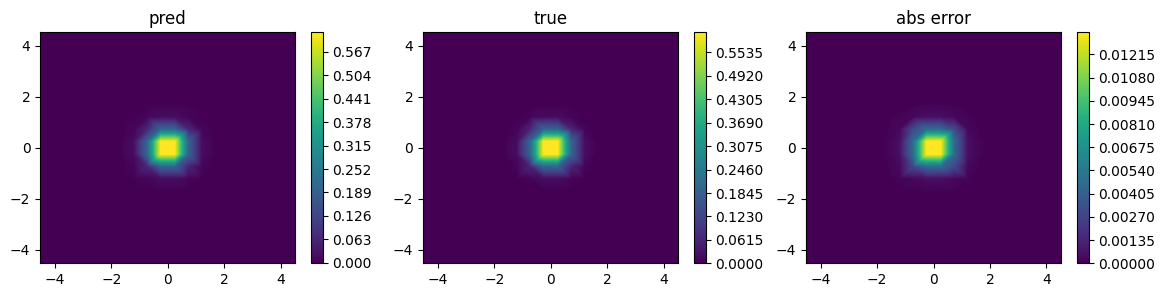

In [200]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
computed = (Kxphi@alpha)
# plt.imshow(computed,interpolation = 'bilinear') 
plt.tricontourf(*interior_points.T,computed,500)
plt.title('pred')
plt.colorbar()
plt.subplot(1,3,2)
true = fp_sol(interior_points,0.1+h)
# plt.imshow(true,interpolation = 'bilinear') 
plt.tricontourf(*interior_points.T,true,500)
plt.title('true')
plt.colorbar()
plt.subplot(1,3,3)
# plt.imshow(true - computed,interpolation = 'bilinear') 
plt.tricontourf(*interior_points.T,jnp.abs(true-computed),500)
plt.title('abs error')
plt.colorbar()
plt.show()

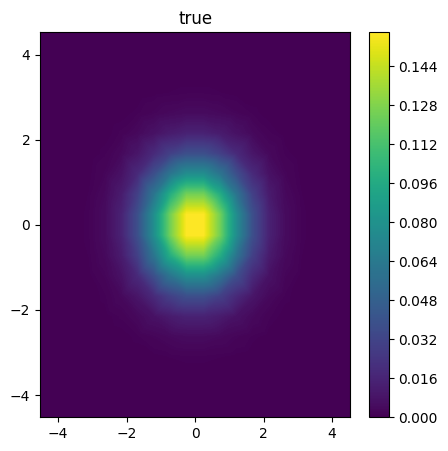

In [201]:
plt.tricontourf(*interior_points.T,fp_sol(interior_points,1.5),500)
plt.title('true')
plt.colorbar()
plt.show()

In [202]:
jnp.mean(fp_sol(interior_points,1.5))

Array(0.01102498, dtype=float64)

In [14]:
num_steps = 10000
initial_time = 0.1
final_time = 1.5
h = (final_time - initial_time)/num_steps
print(h)
def IminP(k,index):
    def op(*args):
        return k(*args) - h * P(k,index)(*args)
    return op

operators = [IminP,BC_hor,BC_vert]
point_blocks = [interior_points,hor_points,vert_points]
n_boundary = len(hor_points) + len(vert_points)
n_interior = len(interior_points)

Kphiphi_blocks = [
    [make_block(k,L,R)(left_points,right_points) for R,right_points in zip(operators,point_blocks)] for L,left_points in zip(operators,point_blocks)
]

Kphiphi = jnp.block(Kphiphi_blocks)

rhs0 = jnp.hstack([fp_sol(interior_points,initial_time),jnp.zeros(n_boundary)])
rhs = rhs0.copy()


# eigs,eigvecs = jnp.linalg.eigh(Kphiphi)
# scaling_vals = jnp.zeros(len(eigs))
# scaling_vals = scaling_vals.at[100:].set(1/(eigs[100:]+1e-8))
# inv_kphiphi = eigvecs@jnp.diag(scaling_vals)@eigvecs.T

from tqdm.auto import tqdm
for i in tqdm(range(num_steps)):
    alpha = jnp.linalg.solve(Kphiphi + 1e-6 * diagpart(Kphiphi),rhs)
    #alpha = inv_kphiphi@rhs
    Kxphi = jnp.hstack([make_block(k,eval_k,operator)(interior_points,points) for operator,points in zip(operators,point_blocks)])
    interior_function_values = Kxphi@alpha
    rhs = jnp.hstack([interior_function_values,jnp.zeros(n_boundary)])

0.00014


100%|██████████| 10000/10000 [20:42<00:00,  8.05it/s]


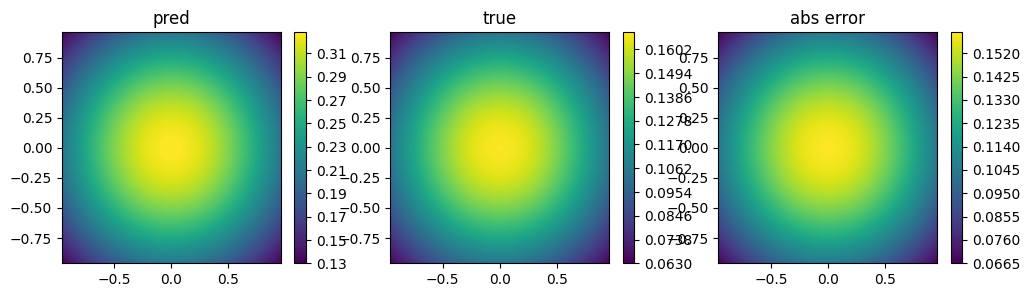

In [15]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
computed = interior_function_values
plt.tricontourf(*interior_points.T,computed,200)
plt.title('pred')
plt.colorbar()
plt.subplot(1,3,2)
true = fp_sol(interior_points,final_time)
plt.tricontourf(*interior_points.T,true,200)
plt.title('true')
plt.colorbar()
plt.subplot(1,3,3)
plt.tricontourf(*interior_points.T,jnp.abs(true-computed),200)
plt.title('abs error')
plt.colorbar()
plt.show()

In [17]:
jnp.mean(computed)

Array(0.24269492, dtype=float64)

In [19]:
jnp.mean(fp_sol(interior_points,0.1))

Array(0.24933728, dtype=float64)

In [20]:
jnp.mean(fp_sol(interior_points,final_time))

Array(0.12225146, dtype=float64)